In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns

# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler
ray.init(log_to_driver=False)

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

_TARGET_STK = 'MSFT'
pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False

2024-01-25 07:49:49,935	INFO worker.py:1724 -- Started a local Ray instance.


In [2]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = [_TARGET_STK]
# ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['VIXCLS', 'SP500', 'DJIA']

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)
# stk_data = web.get_data_yahoo(stk_tickers, start, end)
stk_data = yfin.download(stk_tickers, start, end).dropna()
# ccy_data = web.DataReader(ccy_tickers, 'fred', start, end).dropna()
idx_data = web.DataReader(idx_tickers, 'fred', start, end).dropna()

print(stk_data)
# print(ccy_data)
print(idx_data)

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2014-01-02   37.349998   37.400002   37.099998   37.160000   31.290827  30632200
2014-01-03   37.200001   37.220001   36.599998   36.910000   31.080299  31134800
2014-01-06   36.849998   36.889999   36.110001   36.130001   30.423492  43603700
2014-01-07   36.330002   36.490002   36.209999   36.410000   30.659283  35802800
2014-01-08   36.000000   36.139999   35.580002   35.759998   30.111935  59971700
...                ...         ...         ...         ...         ...       ...
2023-12-22  373.679993  375.179993  372.709991  374.579987  374.579987  17091100
2023-12-26  375.000000  376.940002  373.500000  374.660004  374.660004  12673100
2023-12-27  373.690002  375.059998  372.809998  374.070007  374.070007  14905400
2023-12-28  375.369995  376.459991  374.

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation_size = 0.2
epoch_num = 200
batch_size = 32
log_dir = f'runs/{_TARGET_STK}'

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class LSTMDataSet(Dataset):
    def __init__(self, X, Y, seq_len, features):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
        self.features = features
    def __len__(self):
        return len(self.X) - self.seq_len + 1
    
    def __getitem__(self, idx):
        return (torch.tensor(np.array(self.X[idx: idx + self.seq_len].loc[:, self.features]), dtype=torch.float32),
                torch.tensor(np.array(self.Y.iloc[idx + self.seq_len - 1,:]), dtype=torch.float32))


In [5]:
from torch import nn
class StockPricePredictionLSTM(nn.Module):
    def __init__(self, seq_len, input_size, hidden_size, num_layers, num_fc_layers, activation_type):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if (out_features <= 1):
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU() if activation_type == 1 else
                          nn.Sigmoid()) if activation_type == 2 else nn.Tanh()
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)
            # print(f"{m.in_features},{m.out_features}")

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


In [6]:
import math 
from sklearn.metrics import mean_squared_error

def eval_dl_method(model, dl, criterion=None, device=device):
    model.eval()
    y_gt = []
    y_pred = []
    vloss = 0.0
    for i, (x, y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        if criterion != None:
            vloss += criterion(outputs, y).item()
        # print(f"{i}:{vloss}")
        y_gt.extend(y.cpu().detach().numpy().reshape(-1))
        y_pred.extend(outputs.cpu().detach().numpy().reshape(-1))
    
    return (math.sqrt(mean_squared_error(y_gt, y_pred)) if np.isnan(y_pred).any() == False else 9999, y_gt, y_pred, vloss)

In [7]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper


def gen_analysis_data(stock_name, return_period):
    import pandas_ta
    data = stk_data #.xs(stock_name, axis=1, level=1)
    
    data = pd.concat([data.ta.percent_return(length=return_period, prefix=stock_name),
                        data.ta.adosc(prefix=stock_name),
                        data.ta.kvo(prefix=stock_name), 
                        data.ta.rsi(close='Adj Close', length=10, prefix=stock_name)/100,
                        data.ta.rsi(close='Adj Close', length=30, prefix=stock_name)/100,
                        data.ta.rsi(close='Adj Close', length=200, prefix=stock_name)/100,
                        data.ta.stoch(k=10, prefix=stock_name)/100,
                        data.ta.stoch(k=30, prefix=stock_name)/100,
                        data.ta.stoch(k=200, prefix=stock_name)/100],
                        axis=1)
    data = data.dropna().astype('float32')
    return data

def prepare_dataloader(return_period, seq_len):
    Target_Data = gen_analysis_data(_TARGET_STK, return_period)
    # GOOGL_Data = gen_analysis_data('GOOGL', return_period)
    # AMD_Data = gen_analysis_data('AMD', return_period)

    X1 = Target_Data # pd.concat([Target_Data, GOOGL_Data, AMD_Data], axis=1)

    # X2 = ccy_data.pct_change(return_period).dropna()
    # X2 = X2.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X2.columns.to_list()})

    X3 = pd.concat([idx_data['SP500'].pct_change(return_period), idx_data['DJIA'].pct_change(return_period)], axis=1)
    X3 = X3.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X3.columns.to_list()})
    X3 = pd.concat([idx_data['VIXCLS'], X3], axis=1).dropna()

    X1_X2_X3 = pd.concat([X1, X3], axis=1).dropna()  # pd.concat([X1, X2, X3], axis=1).dropna()
    features = X1_X2_X3.columns.to_list()

    Y_raw = stk_data.loc[:, 'Adj Close'].to_frame().pct_change(return_period).shift(-return_period).dropna().astype('float32')
    Y_raw.columns = [f"{_TARGET_STK}_pred_{return_period}"]

    dataset = pd.concat([Y_raw, X1_X2_X3], axis=1).dropna()

    X = dataset.loc[:, X1_X2_X3.columns]
    Y = dataset.loc[:, Y_raw.columns]

    train_size = int(len(X) * (1 - validation_size))
    X_train = X.iloc[0:train_size].loc[:,features]
    Y_train = Y.iloc[0:train_size]
    X_test  = X.iloc[train_size - seq_len + 1:len(X)].loc[:, features]
    Y_test  = Y.iloc[train_size - seq_len + 1:len(Y)]

    X_dfm = DataFrameMapper(
        [ ([column], StandardScaler()) for column in X_train.columns.to_list()]
        , input_df=True, df_out=True)
    X_train = X_dfm.fit_transform(X_train)
    X_test = X_dfm.transform(X_test)

    train_loader = DataLoader(LSTMDataSet(X_train, Y_train, seq_len, features), batch_size=batch_size)
    test_loader = DataLoader(LSTMDataSet(X_test, Y_test, seq_len,features), batch_size=batch_size)

    return train_loader, test_loader, features

In [8]:
def save_model(model, config, file_path):
    state = {
        'time': str(datetime.now()),
        'model_state': model.state_dict(),
        'input_size': model.input_size,
        'config': config            
    }
    torch.save(state, file_path)

def load_model(file_path):
    data_dict = torch.load(file_path)
    config = data_dict['config']    
    model = StockPricePredictionLSTM(config['seq_len'], input_size=data_dict['input_size'],
                                     hidden_size=int(config['hidden_size']),num_layers=int(config['num_layers']),
                                     num_fc_layers=int(config['num_fc_layers']), activation_type=int(config['activation_type']))

    model.load_state_dict(data_dict['model_state'])
    return model, config


In [9]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore')

def do_train(model, optimizer, train_dl, test_dl, id_str, config, writer):
    criterion = torch.nn.MSELoss()

    model_name = f"{log_dir}/{id_str}.pt"
    best_loss = 999999999    
    total_loss = 0.0
    total_vloss = 0.0
    for epoch in tqdm(range(epoch_num)):
        model.train()
        running_loss = 0.0
        
        for i, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                save_model(model, config, model_name)
                # torch.save(model.state_dict(), model_name)

        with torch.no_grad():
            (testScore, test_y_gt, test_y_pred, running_vloss)  = eval_dl_method(model, test_dl, criterion)
            train.report({"mse_score":testScore})
            
        writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : running_loss / len(train_dl), 'Validation' : running_vloss / len(test_dl) },
                            epoch + 1)
        total_loss += running_loss / len(train_dl)
        total_vloss += running_vloss / len(test_dl)

        writer.flush()
        
    return {'Train loss':total_loss/epoch_num, 'Validation loss': total_vloss/epoch_num}

def train_LSTM(config):
    return_period = config["return_period"]
    seq_len = config["seq_len"]
    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    num_fc_layers = config["num_fc_layers"]
    activation_type = config["activation_type"]

    # id_str = f"{return_period}_{seq_len}_{lr}_{momentum}_{optim_type}_{num_layers}_{hidden_size}_{num_fc_layers}_{activation_type}"
    id_str = "_".join(str(v) if v < 1 else f'{v:g}' for v in config.values())
    print(id_str)
    writer = SummaryWriter(f"{log_dir}/{id_str}")    

    train_loader, test_loader, features = prepare_dataloader(return_period, seq_len)
    model = StockPricePredictionLSTM(seq_len, input_size=len(features),
                                     hidden_size=hidden_size,num_layers=num_layers,
                                     num_fc_layers=num_fc_layers, activation_type=activation_type)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) if optim_type == 1 else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    metric_dict = do_train(model, optimizer, train_loader, test_loader, id_str, config, writer)
    writer.add_hparams(
        config,
        metric_dict
    )
    writer.close()


2024-01-23 14:38:19.410694: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 14:38:19.411759: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 14:38:19.432633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 14:38:19.764407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'{_TARGET_STK}/{time_str}'
config={
    "return_period":5,
    "seq_len":5,
    "lr":0.1,
    "momentum":0.484742,
    "optim_type":2,
    "num_layers":4,
    "hidden_size":128,
    "num_fc_layers":3,
    "activation_type":1
}

train_LSTM(config)

In [26]:
search_space = {
    "return_period": tune.grid_search([5]), #[2,3,5,10]
    "seq_len": tune.grid_search([3, 5, 10]),
    "lr": tune.grid_search([0.01]), #[0.001, 0.01, 0.1]
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([2]), # [1, 2]
    "num_layers": tune.grid_search([2, 4, 8]), #[1, 2, 4, 8]
    "hidden_size": tune.grid_search([8, 32, 64, 128]), #[8, 16, 32, 64, 128]
    "num_fc_layers": tune.grid_search([1, 2, 3]), #1, 2, 3]),
    "activation_type": tune.grid_search([2]) #, 2, 3])
}

turning_parameters = []
total_configs = 1
for k, v in search_space.items():
    if type(v).__name__ == 'dict' and list(v.keys())[0] == 'grid_search' and len(list(v.values())[0]) > 1:
        turning_parameters.append(k)
        total_configs *= len(list(v.values())[0])
print(turning_parameters)
print(f"Total count of configs = {total_configs}")


['seq_len', 'num_layers', 'hidden_size', 'num_fc_layers']
Total count of configs = 108


In [27]:
import warnings
warnings.filterwarnings('ignore', category=Warning)

time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'{_TARGET_STK}/{time_str}'

analysis = tune.run(train_LSTM, 
                    config=search_space,
                    resources_per_trial={'cpu':0.1, 'gpu':0.1},
                    metric="mse_score",
                    mode="min")

2024-01-23 15:16:05,459	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,mse_score
train_LSTM_61ff3_00000,0.0427209
train_LSTM_61ff3_00001,0.0443204
train_LSTM_61ff3_00002,0.0456219
train_LSTM_61ff3_00003,0.0571641
train_LSTM_61ff3_00004,0.0409541
train_LSTM_61ff3_00005,0.0430119
train_LSTM_61ff3_00006,0.0457223
train_LSTM_61ff3_00007,0.0583108
train_LSTM_61ff3_00008,0.0392943
train_LSTM_61ff3_00009,0.0390935


2024-01-23 15:52:12,734	INFO tune.py:1042 -- Total run time: 2167.27 seconds (2167.25 seconds for the tuning loop).


In [28]:
mse_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    # if trial.empty == False:
    d = pd.DataFrame.from_dict({"mse_score": trial.describe().loc['mean', 'mse_score'], "trial_id": trial.loc[0:0,'trial_id'] })
    # else:
    #     d = pd.DataFrame.from_dict({"mse_score": [np.NaN], "trial_id": [np.NaN]})
    mse_list.append(d)
mse_df = pd.concat(mse_list)
mse_df = mse_df.reset_index().loc[:, ["mse_score", "trial_id"]]
print(mse_df)


     mse_score     trial_id
0      0.04429  61ff3_00000
1      0.04382  61ff3_00001
2      0.04441  61ff3_00002
3      0.05290  61ff3_00003
4      0.04123  61ff3_00004
..         ...          ...
103    0.04128  61ff3_00103
104    0.03918  61ff3_00104
105    0.03914  61ff3_00105
106    0.03921  61ff3_00106
107    0.04024  61ff3_00107

[108 rows x 2 columns]


In [29]:
import shutil

config_df = pd.DataFrame(analysis.get_all_configs().values())
# print(config_df)
results = pd.concat([mse_df, config_df], axis=1)
# print(results)

sorted_results = results.sort_values(by="mse_score")
# print(sorted_results.head(100))
sorted_results_file = f"{_TARGET_STK}_sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]].to_dict()
id_str = "_".join(str(v) if v < 1 else f'{v:g}' for v in best_config.values())
best_model_name = f"{log_dir}/{id_str}.pt"
print(best_model_name)
shutil.copy(best_model_name, f"{_TARGET_STK}.pt")

# summary = pd.DataFrame(index=sorted_results.describe().index.values)
# for hperparameter_name in turning_parameters: #['optim_type', 'num_layers', 'hidden_size', 'num_fc_layers', 'activation_type']:
#     parameter_group = sorted_results.groupby(hperparameter_name)
#     for g in parameter_group:
#         summary[f"{hperparameter_name}_{g[0]}"] = g[1].describe()['mse_score']
# print(summary)



/mnt/AIWorkSpace/work/fin-ml/runs/MSFT/2024-01-23_15.16.05/5_5_0.01_0.32400661960813776_2_2_32_3_2.pt


'MSFT.pt'

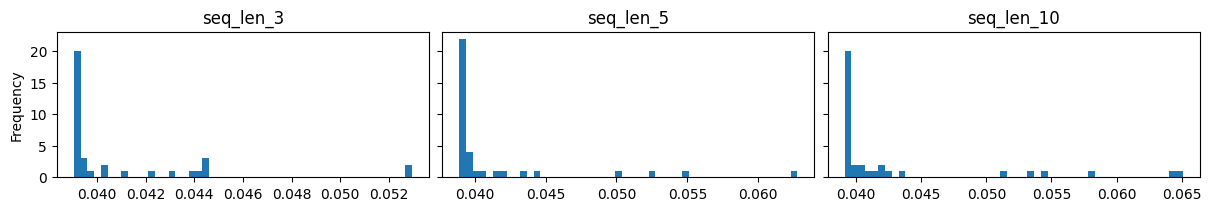

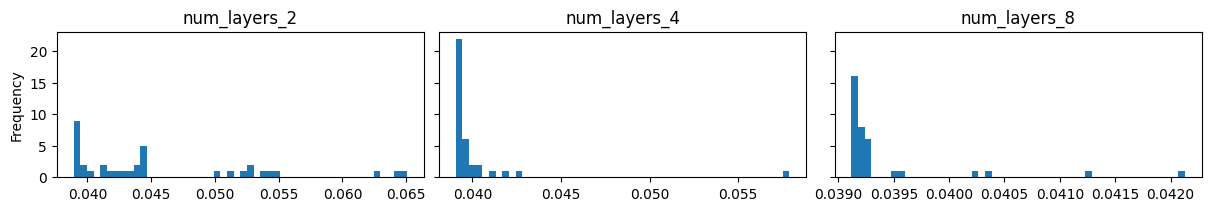

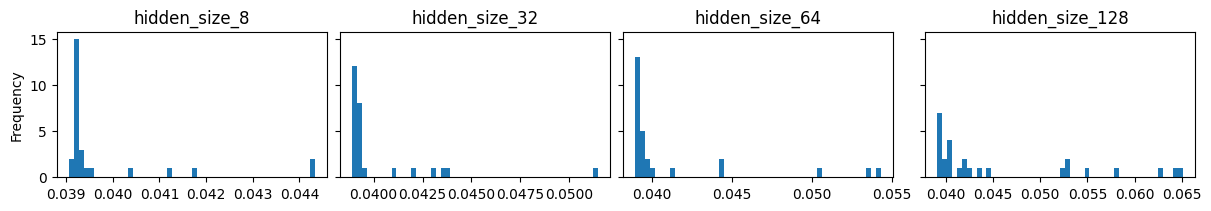

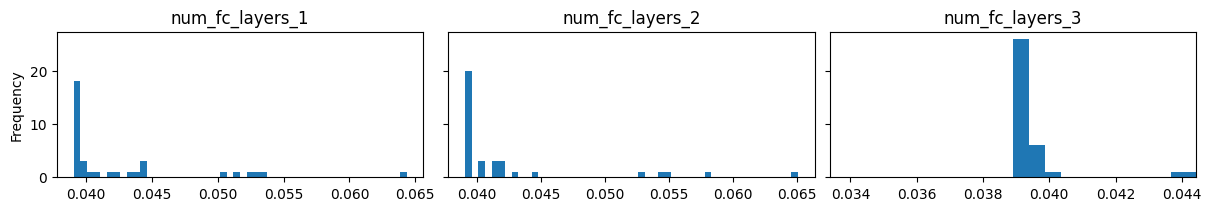

In [30]:
mse_desc = sorted_results['mse_score'].astype('float32').describe()
xlimit_range = [mse_desc['min'] - mse_desc['std'], mse_desc['min'] + mse_desc['std']]
for hperparameter_name in turning_parameters:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(1, len(parameter_group), layout='constrained', sharex=False, sharey=True, figsize=(12,2))
    for i, g in enumerate(parameter_group):
        g[1]['mse_score'].astype('float32').plot(kind='hist',bins=50, subplots=True,sharex=False,sharey=True,ax=axs[i])
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")
        
pyplot.xlim(xlimit_range)
pyplot.show()

In [31]:
sorted_results_file = f"{_TARGET_STK}_sorted_results.csv"
sorted_results = pd.read_csv(sorted_results_file, dtype='str')
best_config = sorted_results.loc[0]
print(best_config)
# id_str_of_best = f"5_5_0.01_{best_config.momentum}_{best_config.optim_type}_{best_config.num_layers}_{best_config.hidden_size}_{best_config.num_fc_layers}_{best_config.activation_type}"
# best_model_name = f"/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}/{id_str_of_best}.pt"
# print(best_model_name)

Unnamed: 0                          45
mse_score          0.03891150102078398
trial_id                   61ff3_00045
return_period                        5
seq_len                              5
lr                                0.01
momentum           0.32400661960813776
optim_type                           2
num_layers                           2
hidden_size                         32
num_fc_layers                        3
activation_type                      2
Name: 0, dtype: object


In [32]:
import math 
from sklearn.metrics import mean_squared_error

pd.set_option('display.precision', 5)

model, config = load_model(f"{_TARGET_STK}.pt")
model.to(device)

train_loader, test_loader, features = prepare_dataloader(config["return_period"], config["seq_len"])
model.eval()

(trainScore, train_y_gt, train_y_pred, _)= eval_dl_method(model, train_loader, device=device)
(testScore, test_y_gt, test_y_pred, _)  = eval_dl_method(model, test_loader, device=device)
print(test_y_pred)
print(f"Train RMSE: {trainScore:.2f}\nTest RMSE: {testScore:.2f}")


[0.009423612, 0.010572968, 0.009850619, 0.008386103, 0.005403472, 0.0026841145, 0.000443561, -0.0011607278, -0.00020101853, 0.0038033407, 0.007577492, 0.008670298, 0.008913903, 0.008524684, 0.0077807885, 0.0063561182, 0.0047831517, 0.0029023718, 0.0010744017, -0.00085684843, -0.0027294029, -0.0034762342, -0.0033334214, -0.002433287, -0.0018090922, -0.0015236754, -0.0017954428, -0.0012835432, -0.00063890405, 0.00013090484, 0.0011305939, 0.0030506533, 0.00436881, 0.0063598882, 0.009416876, 0.011399193, 0.010590507, 0.010325132, 0.010209842, 0.00912909, 0.0076039266, 0.00695136, 0.0069224816, 0.0062163454, 0.006815536, 0.006038515, 0.005204005, 0.0044689905, 0.0038232189, 0.0042149704, 0.0045802724, 0.005235223, 0.0064130705, 0.008751018, 0.009738056, 0.011518, 0.012182621, 0.011715708, 0.010487778, 0.009706287, 0.00900696, 0.00854562, 0.008664949, 0.008068381, 0.0068091135, 0.0049188863, 0.0032569896, 0.001912443, 0.00013753586, -0.0009386409, -0.00031951256, -0.00020726211, 0.0011313539

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2022-02-15 300.01001 300.79999 297.01999 300.47000  295.06436  27058300
2022-02-16 298.37000 300.87000 293.67999 299.50000  294.71994  29982100
2022-02-17 296.35999 296.79999 290.00000 290.73001  286.08994  32461600
2022-02-18 293.04999 293.85999 286.31000 287.92999  283.33459  34264000
2022-02-22 285.00000 291.54001 284.50000 287.72000  283.12796  41736100
...              ...       ...       ...       ...        ...       ...
2023-12-15 366.85001 372.39999 366.28000 370.73001  370.73001  78478200
2023-12-18 369.45001 373.00000 368.67999 372.64999  372.64999  21802900
2023-12-19 371.48999 373.26001 369.84000 373.26001  373.26001  20603700
2023-12-20 375.00000 376.03000 370.53000 370.62000  370.62000  26316700
2023-12-21 372.56000 374.41000 370.04001 373.54001  373.54001  17708000

[466 rows x 6 columns]


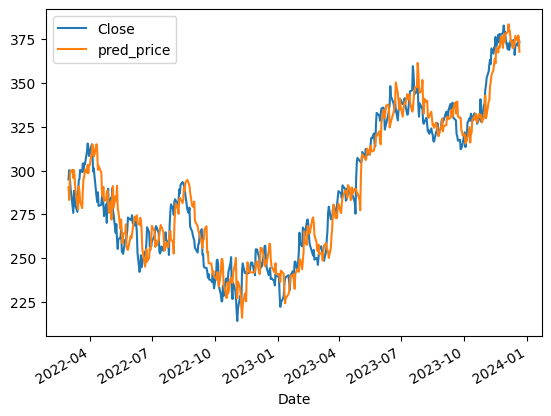

In [33]:
target_raw = stk_data.loc[test_loader.dataset.X.index.values]
print(target_raw)
target_raw = target_raw.drop(target_raw.index[range(config["seq_len"] - 1)], axis=0)

test_y_pred_df = pd.DataFrame(index=target_raw.index.copy())
test_y_pred_df['pred_price'] = test_y_pred
test_y_pred_df['pred_price'] = (test_y_pred_df['pred_price'] + 1) * target_raw['Close']
test_y_pred_df = test_y_pred_df.shift(config["return_period"])
tmp_data = pd.concat([target_raw, test_y_pred_df], axis=1).dropna()
tmp_data['Close'].plot()
tmp_data['pred_price'].plot()
pyplot.legend()
pyplot.show()
